In [777]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import scipy.stats as st
import glob
from numpy.random import uniform
import librosa
from tqdm import tqdm
from pprint import pprint
import sys
from sklearn.cluster import KMeans

# TODO:
1. new data samples
2. more reduction?
3. listen to pcs
4. try sampling random combinations of pcs

In [155]:
def zero_pad(M):
    maxlen = max(len(r) for r in M)

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z

def trunc(M, p=1):
    mean_len = p*round(np.mean([len(r) for r in M]))
    Z = np.zeros((len(M), mean_len))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row[:mean_len]
    return Z

def norm(m,M):
    all_mins = M.min(axis=1)
    all_maxes = M.max(axis=1)
    likely_min = all_mins.mean() - 2 * all_mins.std()
    likely_max = all_maxes.mean() + 2 * all_maxes.std()
    return (m - likely_min)/(likely_max-likely_min)
    #return (m - M.min(axis=0).mean())/(M.max(axis=0).mean()-M.min(axis=0).mean())

# Load the Samples

In [3]:
# returns the fundamental frequency of a list of samples in herz or by note name
# by identifying the relative peaks in the fourier transform
def get_fundamental(x, samplerate, note_name = False):
    x_f = np.fft.rfft(x)
    fs = np.fft.rfftfreq(len(x), 1/samplerate)
    #plt.plot(fs[:30000], x_f[:30000])
    # oh... lol... I didn't know how to do fft with non-1 samplerate..., but usually one is fine
    for rel_thresh in np.linspace(1/5, 0.01, 10):
        peaks = signal.find_peaks(np.abs(x_f), height=np.max(np.abs(x_f))*rel_thresh)[0]
        if peaks.any():
            break
    else:
        return None
    freq_index = peaks[0]
    freq = round(fs[freq_index], 1)

    if not note_name:
        return freq
    else:
        return librosa.hz_to_note(freq)

In [99]:
def load_X(downscale = 3, p=None, maxlen=100000, test_quality=False):
    """
    downsample allows you 
    can either truncate the final arr
    """
    count = 0
    samples_arr = []
    file_descs = []
    files = glob.glob('TinySOL/*/*/*/*.wav')
    #print('Row:\t Filename:')
    for filename in tqdm(files):
        try:
            samplerate, samples = wavfile.read(filename)
            if len(samples.shape) > 1:
                samples = samples[:,0]
            if len(samples) <= 430000:
                abbrev_name = filename.split('/')[4][:-4]
                
                if maxlen:
                    samples = samples[:maxlen]
                    
                reduced_samples = signal.decimate(samples, downscale) #, axis=1)
                #note_name = get_fundamental(reduced_samples, samplerate//downscale, note_name = True)
                
                # only use correctly labelled fundamental freqs
                #if note_name.replace('♯', '#') in abbrev_name:
                samples_arr.append(reduced_samples)
                file_descs.append(abbrev_name)
                #print(count,'\t'+abbrev_name, '\t', note_name)
                count += 1
        except ValueError:
            print('reading failed for ' + filename)
    
    samplerate = samplerate//downscale
    if p:
        X = trunc(samples_arr, p)
    else:
        X = zero_pad(samples_arr)
        
    # remove any still incorrectly labelled fundamental freqs
    freq_hats = map(lambda x: get_fundamental(x, samplerate, note_name=True), X)
    freq_hats = list(map(lambda x: x.replace('♯', '#'), freq_hats))
    wrong_i = [i for i, (f, desc) in enumerate(zip(freq_hats, file_descs)) if f not in desc]
    X = np.delete(X, wrong_i, axis=0)
    # also update file_descs
    for index in sorted(wrong_i, reverse=True):
        del file_descs[index]
        
    if test_quality:
        wavfile.write(f'out/downsampled.wav', samplerate, norm(X[0], X))
    
    return X, samplerate, file_descs

In [100]:
X, X_samplerate, X_file_descs = load_X(test_quality=True)

100%|██████████| 2913/2913 [00:07<00:00, 371.51it/s]


# STFT Analysis

In [302]:
test_embed.shape

(180, 68)

In [809]:
X_f_no_t = np.fft.rfft(X)

In [828]:
signal.find_peaks(np.abs(X_f_no_t[0]), height=np.max(np.abs(X_f_no_t[0]))*0.1)[0].shape

(104,)

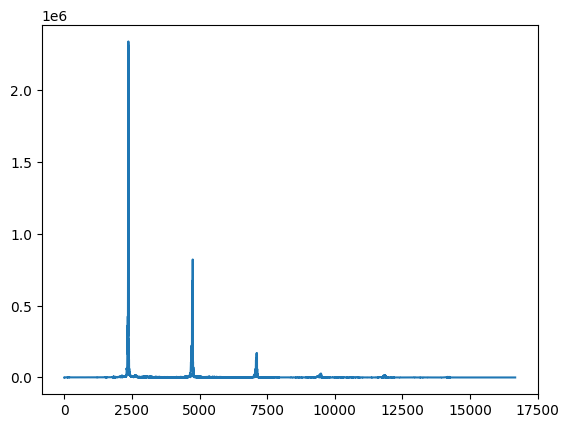

In [831]:
plt.plot(np.abs(X_f_no_t[2]))

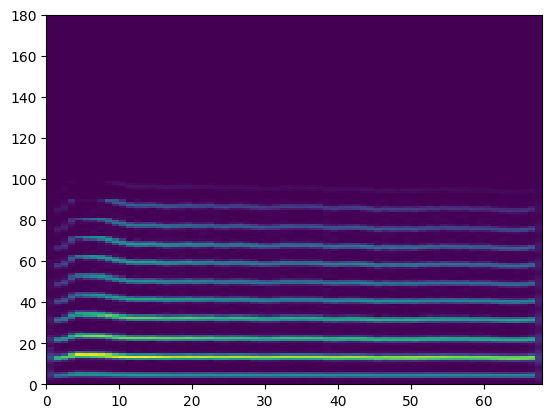

In [316]:
plt.pcolormesh(np.abs(test_embed))

In [ ]:
t_f_ps = np.sum(test_embed.reshape((180, 1//5, 5)), axis=2)

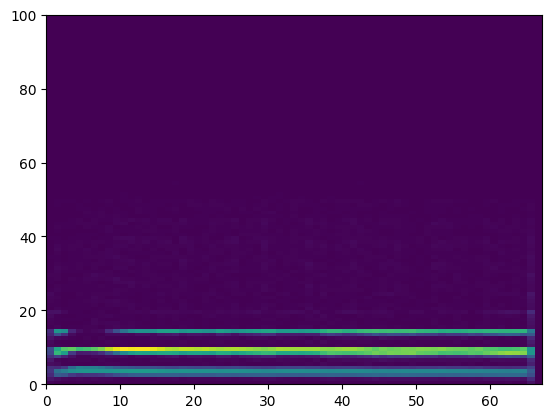

In [373]:
plt.pcolormesh(np.abs(test_embed))

In [384]:
test_embed.shape

(220, 68)

In [385]:
np.transpose(test_embed, (1,0)).shape

(68, 220)

In [395]:
test_embed.shape

(220, 68)

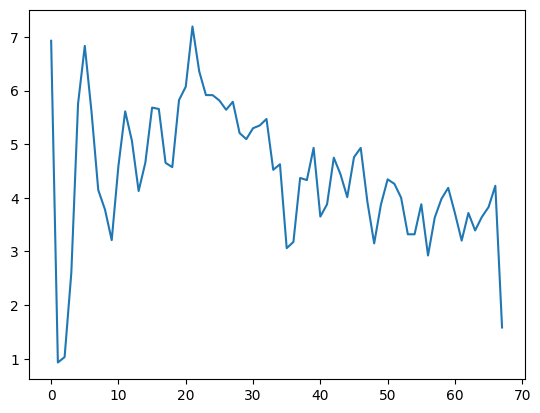

In [440]:
plt.plot([np.sum(np.abs(x), axis=0) for x in np.vsplit(test_embed, 20)][11])

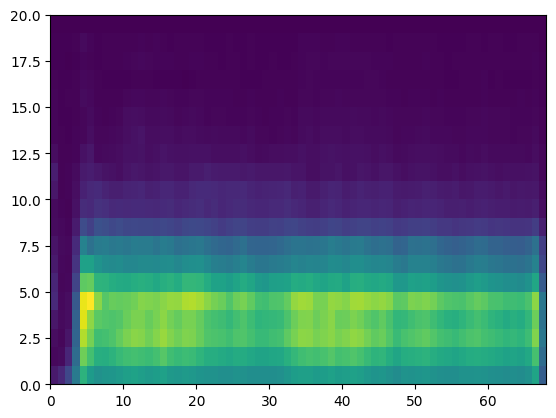

In [436]:
plt.pcolormesh(np.vstack([np.sum(np.abs(x), axis=0) for x in np.vsplit(test_embed, 20)]))

In [658]:
# take the fourier transform of the entire data matrix
# convert the data matrix of amp for each (example, sample) to amp for each (example, freq, time)
def rstft(x, samplerate):
    f, t, spec = signal.stft(x, samplerate, nperseg=1000)
    return np.abs(spec), f, t

def idx_of_partial(freq, freqs):
    return np.argmin(np.abs(freqs - freq))

def get_partials(fund, freqs, num_partials=20, partial_width=5):
    partials = fund*np.arange(1,num_partials)
    wide_partials = []
    off = partial_width//2
    for freq in partials:
        if freq <= np.max(freqs):
            partial_idx = idx_of_partial(freq, freqs)
        else: 
            break
        for i in range(partial_width):
            band_partial_idx = partial_idx+i-off
            if band_partial_idx < len(freqs):
                wide_partials.append(freqs[band_partial_idx])
            
    return wide_partials

def partial_embedding(x, x_fund, freqs, samplerate, num_partials=20, partial_width=5):
    """
    Unfortunately, the full fourier transform is pretty sparse, and too big to perform SVD on directly
    Instead, we have to make a denser embedding (which we can later invert) that consists of the
    amplitude envelopes of the first num_partials partials.
    Vibrato, however, means that amplitudes can be spread across neighboring partials, so we
    can include surrounding partials using the partial_width argument
    This makes the embedding larger by a factor of partial_width, but results in significantly
    less loss of information, so inverting the embedding sounds much more like the original sound
    """
    x_f = rstft(x, samplerate)[0]
    embedding = np.zeros((num_partials*partial_width, x_f.shape[1]))
    
    row = 0
    partials = get_partials(x_fund, freqs, num_partials, partial_width)
    for row, freq in enumerate(partials):
        if freq <= np.max(freqs):
            partial_idx = idx_of_partial(freq, freqs)
        else: 
            break
            
        if partial_idx < min(len(x_f), len(freqs)):
            embedding[row] = x_f[partial_idx]
        
    emb_red = np.vstack([np.sum(x, axis=0) for x in np.vsplit(embedding, num_partials)])
        
    return emb_red, get_partials(x_fund, freqs, num_partials, 1)

    
    return embedding, partials

def smooth(x, sigma):
    # smooth to remove vibrato in get_freq, or just remove noise
    # using gaussian kernel with sigma=2
    kern_domain = np.linspace(-2, 2, 21+1)
    gaussian_kernel = st.norm.pdf(kern_domain, scale=sigma)
    return np.convolve(x, gaussian_kernel, mode='same')


def embedding_inverse(embedded, partials, freqs, samplerate, partial_width=5):
    """
    This function is the inverse of partial_embedding:
    given a partials-only embedding, return approximation of original x
    Thus, we will need it to get a soundfile back from a projected pca vector
    """
    x_f = np.zeros((len(freqs), embedded.shape[1]))
    
    for i in range(len(partials)):
        p_ind = idx_of_partial(partials[i], freqs)
        x_f[p_ind] = embedded[i]
        
    return x_f

In [563]:
# this is the data matrix with each row being replaced by its full fourier transform 
# we will use it to compare to X_f_embed which consists of the embedded fourier transforms
X_f, freqs, t = rstft(X, X_samplerate)

# Testing the Partial Embeddings

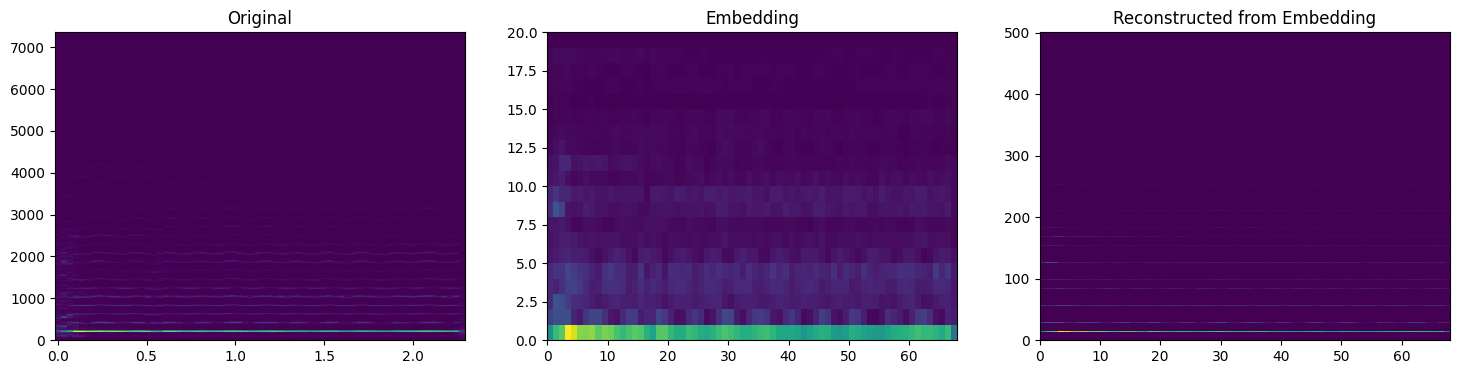

In [839]:
test_ind = 499
test_x = X[test_ind]
pwidth = 11
test_fund = get_fundamental(test_x, X_samplerate)
test_embed, test_partials = partial_embedding(test_x, test_fund, freqs, X_samplerate, num_partials=20, partial_width=pwidth)
test_x_f = embedding_inverse(test_embed, test_partials, freqs, X_samplerate, partial_width=pwidth)

nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*6,nrows*4))

axs[0].set_title('Original')
axs[1].set_title('Embedding')
axs[2].set_title('Reconstructed from Embedding')

axs[0].pcolormesh(t,freqs,X_f[test_ind])
axs[1].pcolormesh(test_embed)
axs[2].pcolormesh(test_x_f)

In [838]:
file_descs[499]

'Vc-ord-G#3-ff-4c-T15u'

In [841]:
librosa.note_to_hz('G#3')

207.65234878997256

In [840]:
test_embed

array([[2715.80592222, 3776.62163182, 4136.24797884, 5579.21875182,
        5239.08334884, 4558.84630491, 4513.95901445, 4631.30535893,
        4181.35472582, 4441.51235396, 4333.80278459, 3951.46587425,
        3723.72996999, 3949.44237902, 4158.41873871, 4051.24572331,
        3552.04129466, 3218.99028016, 4070.48055987, 4114.68778016,
        3684.6995169 , 3418.42261406, 3436.64353102, 3772.86739147,
        3657.20752789, 3430.4211399 , 3367.6260099 , 3540.83941905,
        3793.74180024, 3989.19759969, 3823.55686018, 3660.56428822,
        3425.70971217, 3470.12203984, 3610.71779514, 3765.72392386,
        3844.86937324, 3630.46661115, 3329.19933889, 3295.61803631,
        3324.39826626, 3220.84159719, 2984.43556463, 3179.44639676,
        3359.21820002, 3545.06148893, 3449.20732569, 3056.98913697,
        2943.12343494, 3073.92338414, 3462.34618908, 3338.17461007,
        3214.6853024 , 3077.73933184, 3021.20723455, 2951.06044518,
        3219.514431  , 3407.83889331, 3445.84133

# Perform PCA

In [234]:
X.mean(axis=0).shape

(33334,)

In [639]:
def pca(X):
    mean = X.mean(axis=0) 
    center = X - mean 
    _, stds, pcs = np.linalg.svd(center/np.sqrt(X.shape[0])) 

    return stds**2, pcs
X_mean = X.mean(axis=0)

In [651]:
# embed the data matrix
num_ps = 20
p_width = 11
embed_row = lambda x: partial_embedding(x, 
                                        get_fundamental(x, samplerate),
                                        freqs, X_samplerate, num_partials=num_ps, 
                                        partial_width=p_width)[0]
X_f_embed = np.apply_along_axis(embed_row, 1, X)
n, dimf, dimt = X_f_embed.shape
X_f_linearized = X_f_embed.reshape(n, dimf*dimt)

In [776]:
X_f_embed

(2679, 20, 68)

In [653]:
X_f_linearized.shape

(2679, 1360)

In [654]:
var_exp, pcs_lin  = pca(X_f_linearized)

In [655]:
pcs_lin.shape

(1360, 1360)

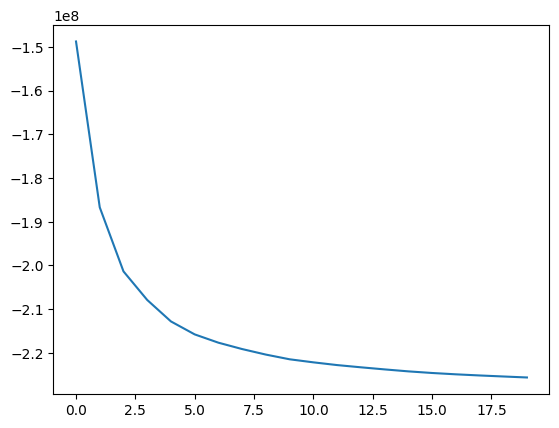

In [683]:
plt.plot(1-np.cumsum(var_exp[:20]))

In [669]:
def reduce_dim(X, mean, pcs, samplerate, num_comps=100):
    X_center = X# - mean
    if len(X_center.shape) == 2:
        X_embed = np.apply_along_axis(embed_row, 1, X_center)
        n, dimf, dimt = X_embed.shape
        X_lin = X_embed.reshape(n, dimf*dimt)
        fund_freqs = [get_fundamental(x, samplerate) for x in X]
    else:
        X_embed = embed_row(X_center)
        dimf, dimt = X_embed.shape
        X_lin = X_embed.reshape(dimf*dimt)
        fund_freqs = [get_fundamental(X, samplerate)]
    X_proj = X_lin @ pcs[:num_comps].T
    return X_proj, fund_freqs

def expand_dim(X_red, mean, pcs, fund, freqs, samplerate, num_partials=20, partial_width=5, num_comps=100):
    X_proj = X_red @ pcs_lin[:num_comps]
    if len(X_red.shape) == 2:
        X_proj = X_proj.reshape(n, dimf, dimt)
        partials_arr = [get_partials(fund_f, freqs, num_partials, 1) for fund_f in fund]
        reconst = [embedding_inverse(x, ps, freqs, samplerate) for x, ps in zip(X_proj, partials_arr)]
    else:
        X_proj = X_proj.reshape(dimf, dimt)
        ps = get_partials(fund, freqs, num_partials, partial_width)
        reconst = embedding_inverse(X_proj, ps, freqs, samplerate)
    reconst = np.array(reconst)
    #reconst = reconst[:, :len(mean)] + mean
    return reconst

In [684]:
n_comps = 10
X_reduced, fund_freqs = reduce_dim(X, X_mean, pcs_lin, X_samplerate, num_comps=n_comps)
X_f_reconst = expand_dim(X_reduced, X_mean, pcs_lin, fund_freqs, freqs, X_samplerate, num_partials=num_ps, partial_width=p_width, num_comps=n_comps)

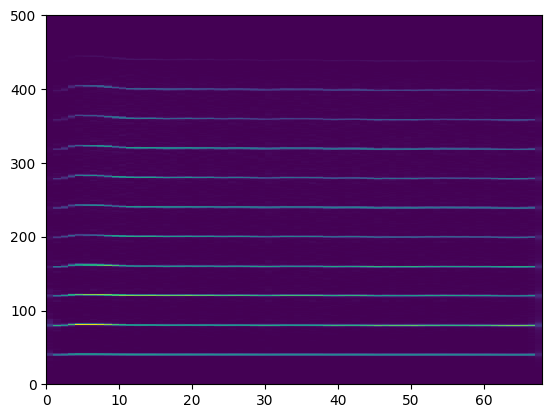

In [685]:
plt.pcolormesh(X_f[0])

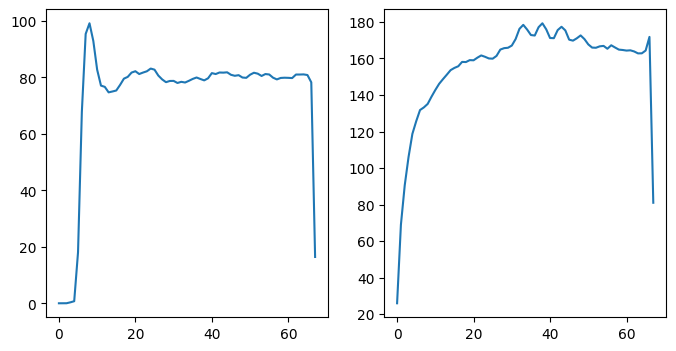

In [749]:
test_ind = 2000
test_fund_ind = np.argmax(X_f_reconst[test_ind].mean(axis=1))

fig,axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(X_f[test_ind, test_fund_ind])
#axs[1].plot(X_f_reconst[test_ind, test_fund_ind])
axs[1].plot((X_reduced[test_ind] @ pcs_lin[:n_comps]).reshape(dimf,dimt)[1])

In [774]:
#old_opts = np.get_printoptions()
np.set_printoptions(**old_opts)

In [834]:
np.set_printoptions(threshold=sys.maxsize)

In [835]:
test_embed

array([[2.58065068e+01, 1.56272241e+02, 3.84975508e+02, 5.06581371e+02,
        5.47441278e+02, 5.41286169e+02, 4.39635706e+02, 4.08417094e+02,
        5.21679117e+02, 6.11638917e+02, 6.04197085e+02, 5.64092725e+02,
        5.25902918e+02, 6.24785719e+02, 7.42649240e+02, 7.62125414e+02,
        5.99991454e+02, 4.74889122e+02, 5.25942427e+02, 6.71257721e+02,
        7.31558692e+02, 7.28019433e+02, 6.12535025e+02, 6.24447220e+02,
        7.56357202e+02, 7.94897164e+02, 7.80587973e+02, 6.50764613e+02,
        5.46535623e+02, 6.32359042e+02, 7.54744819e+02, 8.20104712e+02,
        6.81979956e+02, 5.66165407e+02, 5.57992793e+02, 6.30054590e+02,
        7.10752063e+02, 7.70184895e+02, 6.53563217e+02, 5.98025274e+02,
        6.20967877e+02, 7.13658673e+02, 8.17162686e+02, 7.01361988e+02,
        6.17705800e+02, 6.21012013e+02, 6.77710103e+02, 7.45348800e+02,
        7.22337139e+02, 6.73361846e+02, 6.60625234e+02, 6.39601298e+02,
        6.20661174e+02, 6.10610766e+02, 6.86504380e+02, 5.691404

In [770]:
file_descs.index('Acc-ord-A4-ff-N-N')

1659

In [771]:
(X_reduced[1659] @ pcs_lin[:n_comps]).reshape(dimf,dimt)

array([[ 395.31571744,  679.74516555,  505.37441529,  498.19140344,
         595.97157432,  631.84914867,  649.85214808,  650.0633892 ,
         656.04229135,  661.50435361,  690.57674277,  719.05129384,
         750.06667721,  771.74925027,  777.93562823,  769.74337674,
         786.31008353,  801.58882952,  798.4147532 ,  815.9620162 ,
         837.2938626 ,  845.24559523,  842.38521096,  837.41517825,
         842.64021667,  869.98985834,  880.69739345,  896.29033213,
         901.16516026,  913.03297338,  924.58516723,  910.53435888,
         927.09518213,  941.41044394,  935.75283627,  923.56633823,
         910.34853757,  919.64899166,  914.67819693,  922.2887039 ,
         898.43141576,  882.89909733,  887.66042941,  898.15187496,
         907.28189483,  890.11204349,  861.77978984,  848.59133408,
         860.49651509,  876.84084072,  869.30858394,  845.88965937,
         820.51835236,  824.64136924,  847.96782552,  870.45293608,
         865.43448305,  865.82146061,  875.72328

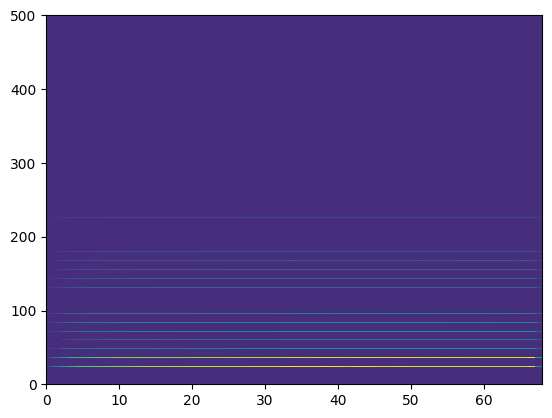

In [746]:
plt.pcolormesh(X_f_reconst[test_ind])

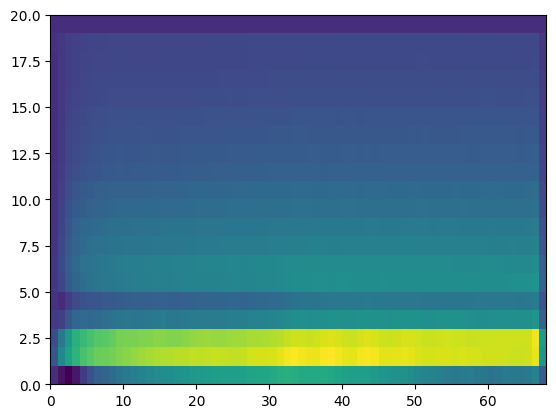

In [745]:
plt.pcolormesh((pcs_lin[:n_comps].reshape(n_comps, dimf, dimt).T @ X_reduced[test_ind]).T

In [747]:
pcs_lin[:n_comps].reshape(n_comps, dimf, dimt).T.shape

(68, 20, 10)

In [732]:
X_reduced[test_ind].shape

(10,)

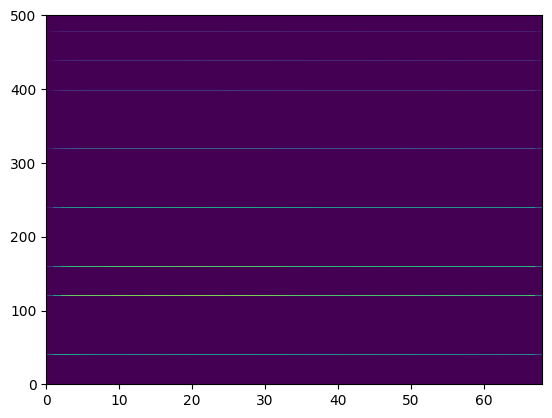

In [686]:
plt.pcolormesh(X_f_reconst[0])

In [799]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_f_linearized)

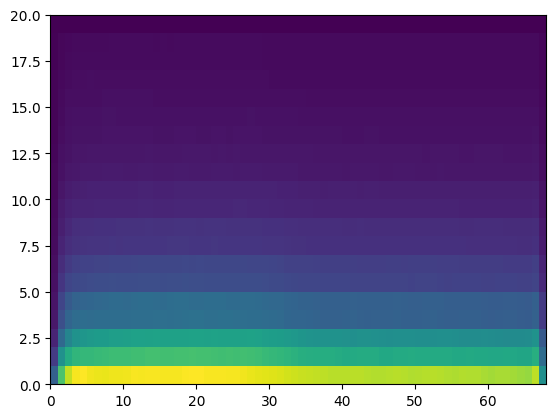

In [808]:
plt.pcolormesh(kmeans.cluster_centers_[3].reshape(X_f_embed[0].shape))